# Variant effect prediction

In [1]:
import warnings
warnings.filterwarnings('ignore')
from datasets import load_dataset
from functools import reduce
import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
from math import sqrt
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, fisher_exact

import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score, PrecisionRecallDisplay
from tqdm import tqdm
tqdm.pandas()

In [2]:
COORDINATES = ["chrom", "pos", "ref", "alt"]

def load_models(V, dataset_path, dataset_name):
    d = Path(f"../../results/preds/{dataset_path}")
    models = dataset_models[dataset_name]
    if not isinstance(models, list):
        models = gather_unique_values(dataset_models[dataset_name])
    for m in tqdm(models):
        model_name = model_renaming.get(m, m)
        model_path = d / f"{m}.parquet"
        V = V.with_columns(pl.read_parquet(model_path, columns="score")["score"].alias(model_name))
    return V

def get_odds_ratio(df, threshold_ns):
    rows = []
    negative_set = df.filter(~pl.col("label")).sort("score")
    for n in threshold_ns:
        threshold = negative_set[n]["score"]
        group_counts = (
            df.group_by(["label", pl.col("score") <= threshold]).len()
            .sort(["label", "score"])["len"].to_numpy().reshape((2,2))
        )
        odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
        rows.append([n, odds_ratio, p_value])
    return pl.DataFrame(rows, schema=["n", "Odds ratio", "p_value"])

def format_number(num):
    """
    Converts a number into a more readable format, using K for thousands, M for millions, etc.
    Args:
    - num: The number to format.
    
    Returns:
    - A formatted string representing the number.
    """
    if num >= 1e9:
        return f'{num/1e9:.1f}B'
    elif num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.1f}K'
    else:
        return str(num)

def plot_curve(V, results, curve, title, save_path=None):
    n_pos, n_neg = results.n_pos.iloc[0], results.n_neg.iloc[0]
    sample_size = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
    title = f"{title}\n{sample_size}"
    if curve == "ROC":
        plot_f = RocCurveDisplay
        metric = "AUROC"
        xlabel = 'False Positive Rate'
        ylabel = 'True Positive Rate'
        random_plot = lambda ax: ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
    elif curve == "PR":
        pos_prop = n_pos / (n_pos + n_neg)
        plot_f = PrecisionRecallDisplay
        metric = "AUPRC"
        xlabel = 'Recall'
        ylabel = 'Precision'
        random_plot = lambda ax: ax.axhline(y=pos_prop, linestyle="--", color="gray")
    
    # note: latest sklearn has argument: plot_chance_level
    fig, ax = plt.subplots(figsize=(3,3))

    for m in results.Model.unique()[::-1]:
        AUC = results[results.Model==m].iloc[0][metric]
        plot_f.from_predictions(V.label, -V[m], name=m, ax=ax, label=f"{m} (AUC={AUC:.3f})", color=palette[m])
        
    random_plot(ax)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    sns.despine()
    
    ax.legend();
    # get handles and labels
    handles, labels = ax.get_legend_handles_labels()
    # reverse the order
    handles, labels = handles[::-1], labels[::-1]
    # create the legend with the reversed order
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title(title);
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")
        

color_neg = sns.color_palette("Dark2")[0]
color_pos = sns.color_palette("Dark2")[1]
palette_label = {
    "gnomAD/\nCommon": color_neg,
    "ClinVar/\nPathogenic": color_pos,
    "COSMIC/\nFrequent": color_pos,
    "OMIM/\nPathogenic": color_pos,
    "gnomAD/\nRare": color_pos,
    
    "Common": color_neg,
    "Rare": color_pos,
}

def barplot(
    df, metric, title, groupby="Consequence",
    width=2, height=2, nrows=1, ncols=1,
    save_path=None, wspace=None, hspace=None,
    x=None, y=None,
):
    if groupby not in df.columns: df[groupby] = "all"
    groups = df[groupby].unique()
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, sharex=False, sharey=False,
        figsize=(width*ncols, height*nrows), squeeze=False,
        gridspec_kw={'wspace': wspace, 'hspace': hspace},
    )

    for group, ax in zip(groups, axes.flat):
        df_g = df[df[groupby]==group].sort_values(metric, ascending=False)
        n_pos, n_neg = df_g.n_pos.iloc[0], df_g.n_neg.iloc[0]

        if metric == "AUROC":
            baseline = 0.5
        elif metric == "AUPRC":
            baseline = n_pos / (n_pos + n_neg)
        elif metric == "Odds ratio":
            baseline = 1

        g = sns.barplot(
            data=df_g,
            y="Model",
            x=metric,
            palette=palette,
            ax=ax,
        )
        sns.despine()
        sample_size = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
        subtitle = f"{group}\n{sample_size}" if len(groups) > 1 else sample_size
        g.set_title(subtitle, fontsize=10)
        g.set(xlim=baseline, ylabel="")

        for bar, model in zip(g.patches, df_g.Model):
            if metric == "Odds ratio":
                text = f'{bar.get_width():.1f}'
                if df_g[df_g.Model==model].p_value.iloc[0] >= 0.05:
                    text = text + " (NS)"
            else:
                text = f'{bar.get_width():.3f}'
            
            g.text(
                max(bar.get_width(), baseline),  # X position, here at the end of the bar
                bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
                text,  # Text to be displayed, formatted to 3 decimal places
                va='center'  # Vertical alignment
            )
        
        #if metric == "Odds ratio":
        #    for index, row in df_g.iterrows():
        #        if row['p_value'] >= 0.05:
        #            g.text(y=index, x=row['Odds ratio'], s='(ns)', ha='right')
        
    plt.suptitle(title, x=x, y=y, fontsize=11)
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

def histplot_label(V, label_pos, label_neg, save_path=None, **kwargs):
    V["label"] = V.label.replace({True: label_pos, False: label_neg})
    plt.figure(figsize=(3,3))
    g = sns.histplot(
        data=V,
        x="GPN-MSA",
        hue="label",
        hue_order=[label_pos, label_neg],
        bins=25,
        stat="density",
        common_norm=False,
        common_bins=True,
        palette=palette_label,
        **kwargs,
    )
    sns.despine()
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")
        
        
def ecdfplot_label(V, save_path=None, **kwargs):
    plt.figure(figsize=(3,3))
    sns.ecdfplot(
        data=V,
        x="GPN-MSA",
        hue="label",
        palette=palette_label,
        **kwargs,
    )
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

In [3]:
plot_dir = "../../results/plots/"

In [4]:
palette = {
    "GPN-MSA": "C0",
    "CADD": "C1",
    "phyloP": "C2",
    "ESM-1b": "C3",
    "NT": "C4",
    "SpliceAI": "C5",
    "Enformer": "C6",
    "HyenaDNA": "C9",
    
    "phyloP-100v": "C2",
    "phyloP-241m": "C7",
    "phastCons-100v": "C8",

    "NT-500m-human-ref": "gray",
    "NT-500m-1000g": "gray",
    "NT-2.5b-1000g": "gray",
    "NT-2.5b-multi-species": "C4",
    
    r"Enformer ($L^1$)": "C6",
    r"Enformer ($L^2$)": "C7",
    r"Enformer ($L^\infty$)": "C8",
    
    "PrimateAI-3D": "black",
}

In [5]:
core_models = [
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    "CADD.RawScore",
    "phyloP",
    "phyloP-Zoonomia",
    "phastCons",
]

nt_model = "InstaDeepAI/nucleotide-transformer-2.5b-multi-species"
hyenadna_model = 'LongSafari/hyenadna-large-1m-seqlen-hf'

ablation_models = pd.read_csv("../../ablation_models.txt", header=None).values.ravel().tolist()[1:]
#ablation_models = []

original_name = "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True"

model_renaming = { 
    # GPN-MSA
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",

    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    
    # HyenaDNA models
    'LongSafari/hyenadna-large-1m-seqlen-hf': "HyenaDNA",
    
    # Other models
    "CADD.RawScore": "CADD",
    "phyloP": "phyloP-100v",
    "phastCons": "phastCons-100v",
    "phyloP-Zoonomia": "phyloP-241m",
}

def gather_unique_values(d):
    unique_values = []
    seen = set()

    def gather_values(nested_dict):
        for value in nested_dict.values():
            if isinstance(value, dict):
                gather_values(value)
            elif isinstance(value, list):
                for item in value:
                    if item not in seen:
                        unique_values.append(item)
                        seen.add(item)

    gather_values(d)

    return unique_values

def apply_to_values(d, f):
    for key, value in d.items():
        if isinstance(value, dict):
            apply_to_values(value, f)
        elif isinstance(value, list):
            d[key] = [f(x) for x in value]
        else:
            d[key] = f(value)

consequence_bundles = {
    "splice_region": [
        "splice_polypyrimidine_tract",
        "splice_region",
        "splice_donor_region",
        "splice_donor",
        "splice_donor_5th_base",
        "splice_acceptor",
    ],
    "start_or_stop": {
        "stop_gained",
        "stop_lost",
        "start_lost",
    }
}
            
dataset_models = {
    "ClinVar": core_models + ["ESM-1b", nt_model, hyenadna_model] + ablation_models, #+ ["PrimateAI-3D"],

    "COSMIC": core_models + ["ESM-1b"] + ablation_models,  #+ ["PrimateAI-3D"],

    "OMIM": {
        "all": core_models + ablation_models,
        "Promoter": core_models + [nt_model],
        "Enhancer": core_models,
        "5' UTR": core_models + [nt_model],
        "3' UTR": core_models + [nt_model],
        "ncRNA": core_models + [nt_model],
    },
    
    "gnomAD": {
        "all": core_models,
        
        "missense": core_models + ["ESM-1b"], # + nt_models[-1:], # + ["PrimateAI-3D"],
        
        "synonymous": core_models,
        "5_prime_UTR": core_models,
        "3_prime_UTR": core_models,
        "upstream_gene": core_models,
        "downstream_gene": core_models,
        
        "intron": core_models + ["SpliceAI"],
        
        "intergenic": core_models,
        "non_coding_transcript_exon": core_models,
        
        "splice_region": core_models + ["SpliceAI"],
        "start_or_stop": core_models,
    },
    
    "gnomAD_Enformer": core_models + ["Enformer_l1", "Enformer_l2", "Enformer_linf"],
    
    "gnomAD_ablation": core_models[:1] + ablation_models,
    
    "ClinVar_benign": core_models + ["ESM-1b"],
    "DMS": core_models + ["ESM-1b"],
}

In [6]:
dataset_path = "results/clinvar/merged"
V_clinvar = (
    pl.read_parquet(f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label"])
    .with_columns(pl.col("label") == "Pathogenic")
)
V_clinvar = (
    load_models(V_clinvar, dataset_path, "ClinVar")
    .unique(COORDINATES, keep="none", maintain_order=True)
)

100%|██████████| 54/54 [00:01<00:00, 31.22it/s]


In [7]:
dataset_path = "results/cosmic/merged"
V_cosmic = (
    pl.read_parquet(f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label"])
    .with_columns(pl.col("label") == "Frequent")
)
V_cosmic = (
    load_models(V_cosmic, dataset_path, "COSMIC")
    .unique(COORDINATES, keep="none", maintain_order=True)
)

100%|██████████| 52/52 [00:00<00:00, 232.59it/s]


In [8]:
dataset_path = "results/omim/merged"
V_omim = (
    pl.read_parquet(f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label", "consequence"])
    .with_columns(pl.col("label") == "Pathogenic")
)
V_omim = (
    load_models(V_omim, dataset_path, "OMIM")
    .unique(COORDINATES, keep="none", maintain_order=True)
)

100%|██████████| 52/52 [00:04<00:00, 11.45it/s]


In [9]:
dataset_path = "results/gnomad/merged/filt"
V_gnomad = (
    pl.read_parquet(f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label", "consequence"])
    .with_columns(
        pl.col("label") == "Rare",
        pl.col("consequence").str.replace("_variant", ""),
    )
)
for new_c, old_cs in consequence_bundles.items():
    V_gnomad = V_gnomad.with_columns(
        pl.when(pl.col("consequence").is_in(old_cs))
        .then(pl.lit(new_c))
        .otherwise(pl.col("consequence"))
        .alias("consequence")
    )
V_gnomad = load_models(V_gnomad, dataset_path, "gnomAD")

100%|██████████| 7/7 [00:35<00:00,  5.01s/it]


In [10]:
dataset_path = "results/variants_enformer/"
V_enformer = (
    pl.read_parquet(f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label"])
    .with_columns(pl.col("label") == "Low-frequency")
)
V_enformer = load_models(V_enformer, dataset_path, "gnomAD_Enformer").unique(COORDINATES)

100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


In [11]:
dataset_path = "results/gnomad/merged/subsampled"
V_gnomad_ablation = (
    pl.read_parquet(f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label"])
    .with_columns(pl.col("label") == "Rare")
)
V_gnomad_ablation = load_models(V_gnomad_ablation, dataset_path, "gnomAD_ablation").unique(COORDINATES)

100%|██████████| 47/47 [00:23<00:00,  2.01it/s]


In [ ]:
dataset_path = "results/clinvar/mis_pat_ben"
V_clinvar_benign = (
    pl.read_parquet(f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label"])
    .with_columns(pl.col("label") == "Pathogenic")
)
V_clinvar_benign = load_models(V_clinvar_benign, dataset_path, "ClinVar_benign").unique(COORDINATES)

100%|██████████| 6/6 [00:00<00:00, 18.41it/s]


In [ ]:
dataset_path = "results/dms/merged"
V_dms = (
    pl.read_parquet(f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label", "DMS"])
)
V_dms = load_models(V_dms, dataset_path, "DMS")

100%|██████████| 6/6 [00:00<00:00, 142.68it/s]


In [ ]:
apply_to_values(dataset_models, lambda m: model_renaming.get(m, m))

## ClinVar pathogenic vs. gnomAD common (missense)

In [16]:
models_clinvar = dataset_models["ClinVar"]
V_clinvar = V_clinvar.drop_nulls(subset=models_clinvar)
n_pos, n_neg = V_clinvar["label"].sum(), (~V_clinvar["label"]).sum()
rows = []
for m in tqdm(models_clinvar):
    y_true = V_clinvar["label"]
    y_score = -V_clinvar[m]
    AUROC = roc_auc_score(y_true, y_score)
    AUPRC = average_precision_score(y_true, y_score)
    rows.append(["all", m, AUROC, AUPRC, n_pos, n_neg])
results_clinvar = pd.DataFrame(
    rows, columns=["Consequence", "Model", "AUROC", "AUPRC", "n_pos", "n_neg"]
).sort_values("AUROC", ascending=False)
results_clinvar.head()

100%|██████████| 54/54 [00:01<00:00, 31.07it/s]


,Consequence,Model,AUROC,AUPRC,n_pos,n_neg
25,all,multiz100way/89/256/128/True/defined.phastCons...,0.969064,0.976373,21273,15402
9,all,multiz100way/89/128/64/True/defined.phastCons....,0.968850,0.976253,21273,15402
26,all,multiz100way/89/256/128/True/defined.phastCons...,0.968727,0.976166,21273,15402
27,all,multiz100way/89/256/128/True/defined.phastCons...,0.968660,0.976051,21273,15402
0,all,GPN-MSA,0.968525,0.975992,21273,15402


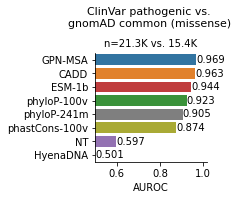

In [18]:
barplot(
    results_clinvar[~results_clinvar.Model.isin(ablation_models)],
    "AUROC",
    "ClinVar pathogenic vs.\ngnomAD common (missense)",
    y=1.2,
    #save_path="clinvar_auroc.svg",
)

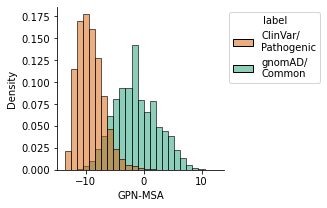

In [20]:
histplot_label(
    V_clinvar.select(["label", "GPN-MSA"]).to_pandas(),
    "ClinVar/\nPathogenic", "gnomAD/\nCommon",
    #save_path="hist_clinvar.svg",
)

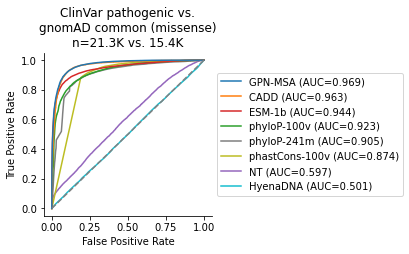

In [22]:
plot_curve(
    V_clinvar.to_pandas(),
    results_clinvar[~results_clinvar.Model.isin(ablation_models)],
    "ROC",
    "ClinVar pathogenic vs.\ngnomAD common (missense)",
    #save_path="clinvar_roc.svg",
)

### Stratifying by conservation

In [23]:
conservation_model = "phyloP-241m"
log_pval_thresh = -np.log10(0.05)  # 1.3
V_clinvar = V_clinvar.with_columns(
    pl.when(pl.col(conservation_model) < -log_pval_thresh).then(pl.lit("conserved"))
    .when(pl.col(conservation_model) > log_pval_thresh).then(pl.lit("accelerated"))
    .otherwise(pl.lit("neutral"))
    .alias("conservation")
)
V_clinvar["conservation"].value_counts()

conservation,count
str,u32
"""accelerated""",2037
"""conserved""",26652
"""neutral""",7986


In [24]:
rows = []
for c in ["all"] + list(V_clinvar["conservation"].unique()):
    V_c = V_clinvar if c == "all" else V_clinvar.filter(conservation=c)
    n_pos, n_neg = V_c["label"].sum(), (~V_c["label"]).sum()
    y_true = V_c["label"] 
    for m in [m for m in models_clinvar if m not in ablation_models]:
        y_score = -V_c[m]
        AUROC = roc_auc_score(y_true, y_score)
        AUPRC = average_precision_score(y_true, y_score)
        rows.append([c, m, AUROC, AUPRC, n_pos, n_neg])
# Conservation called "Consequence" for plotting function convenience
results_clinvar_strat = pd.DataFrame(
    rows, columns=["Consequence", "Model", "AUROC", "AUPRC", "n_pos", "n_neg"]
)
results_clinvar_strat.head()

,Consequence,Model,AUROC,AUPRC,n_pos,n_neg
0,all,GPN-MSA,0.968525,0.975992,21273,15402
1,all,CADD,0.962982,0.968901,21273,15402
2,all,phyloP-100v,0.923292,0.941895,21273,15402
3,all,phyloP-241m,0.904597,0.916929,21273,15402
4,all,phastCons-100v,0.873833,0.855832,21273,15402


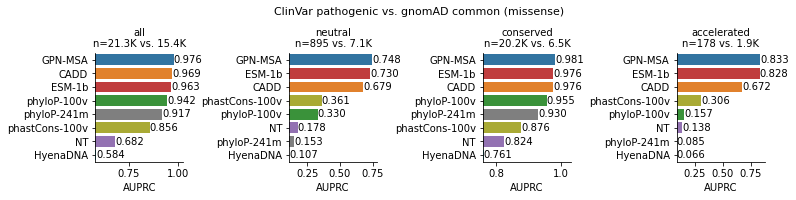

In [26]:
barplot(
    results_clinvar_strat,
    "AUPRC",
    "ClinVar pathogenic vs. gnomAD common (missense)",
    ncols=4, wspace=1.2, width=3, y=1.2,
    #save_path="clinvar_strat_auprc.svg",
)

## COSMIC frequent vs. gnomAD common (missense)

In [27]:
models_cosmic = dataset_models["COSMIC"]
V_cosmic = V_cosmic.drop_nulls(subset=models_cosmic)
n_pos, n_neg = V_cosmic["label"].sum(), (~V_cosmic["label"]).sum()
rows = []
for m in tqdm(models_cosmic):
    y_true = V_cosmic["label"]
    y_score = -V_cosmic[m]
    AUROC = roc_auc_score(y_true, y_score)
    AUPRC = average_precision_score(y_true, y_score)
    rows.append(["all", m, AUROC, AUPRC, n_pos, n_neg])
results_cosmic = pd.DataFrame(
    rows, columns=["Consequence", "Model", "AUROC", "AUPRC", "n_pos", "n_neg"]
).sort_values("AUPRC", ascending=False)
results_cosmic.head()

100%|██████████| 52/52 [00:00<00:00, 123.49it/s]


,Consequence,Model,AUROC,AUPRC,n_pos,n_neg
25,all,multiz100way/89/256/128/True/defined.phastCons...,0.774918,0.375973,183,15399
23,all,multiz100way/89/256/128/True/defined.phastCons...,0.774832,0.363774,183,15399
24,all,multiz100way/89/256/128/True/defined.phastCons...,0.774417,0.358015,183,15399
0,all,GPN-MSA,0.776506,0.354610,183,15399
6,all,multiz100way/89/128/64/True/defined.phastCons....,0.776209,0.349398,183,15399


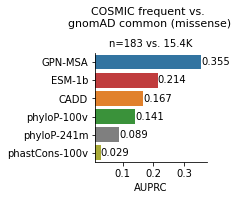

In [29]:
barplot(
    results_cosmic[~results_cosmic.Model.isin(ablation_models)],
    "AUPRC",
    "COSMIC frequent vs. \ngnomAD common (missense)",
    y=1.2,
    #save_path="cosmic_auprc.svg",
)

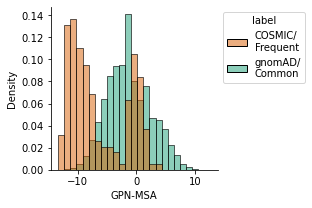

In [30]:
histplot_label(
    V_cosmic.select(["label", "GPN-MSA"]).to_pandas(),
    "COSMIC/\nFrequent", "gnomAD/\nCommon",
    #save_path="hist_cosmic.svg",
)

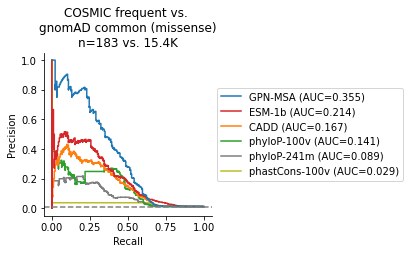

In [31]:
plot_curve(
    V_cosmic.to_pandas(),
    results_cosmic[~results_cosmic.Model.isin(ablation_models)],
    "PR",
    "COSMIC frequent vs. \ngnomAD common (missense)",
    #save_path="cosmic_pr_curve.svg",
)

## OMIM pathogenic vs. gnomAD common (regulatory)

In [32]:
consequence_models = dataset_models["OMIM"]
rows = []
for c in tqdm(consequence_models):
    V_c = V_omim if c == "all" else V_omim.filter(consequence=c)
    V_c = V_c.drop_nulls(subset=consequence_models[c])
    n_pos, n_neg = V_c["label"].sum(), (~V_c["label"]).sum()
    y_true = V_c["label"] 
    for m in consequence_models[c]:
        y_score = -V_c[m]
        AUROC = roc_auc_score(y_true, y_score)
        AUPRC = average_precision_score(y_true, y_score)
        rows.append([c, m, AUROC, AUPRC, n_pos, n_neg])
results_omim = pd.DataFrame(rows, columns=["Consequence", "Model", "AUROC", "AUPRC", "n_pos", "n_neg"])
results_omim.head()

100%|██████████| 6/6 [01:01<00:00, 10.20s/it]


,Consequence,Model,AUROC,AUPRC,n_pos,n_neg
0,all,GPN-MSA,0.930498,0.127152,406,2573918
1,all,CADD,0.939016,0.048271,406,2573918
2,all,phyloP-100v,0.871816,0.037942,406,2573918
3,all,phyloP-241m,0.884964,0.028139,406,2573918
4,all,phastCons-100v,0.830174,0.005947,406,2573918


In [33]:
results_omim.Consequence = results_omim.Consequence.replace({
    "Promoter": "promoter",
    "Enhancer": "enhancer",
})

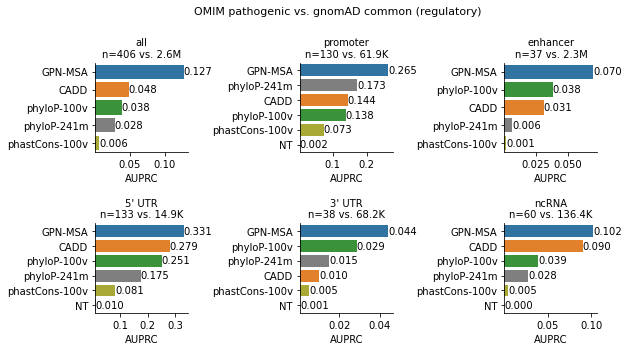

In [36]:
barplot(
    results_omim[~results_omim.Model.isin(ablation_models)],
    "AUPRC",
    "OMIM pathogenic vs. gnomAD common (regulatory)",
    nrows=2, ncols=3, hspace=0.8, wspace=1.2, width=3, height=2.3, y=1.05,
    #save_path="omim_auprc.svg",
)

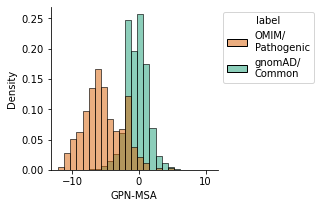

In [37]:
histplot_label(
    V_omim.select(["label", "GPN-MSA"]).to_pandas(),
    "OMIM/\nPathogenic", "gnomAD/\nCommon",
    #save_path="hist_omim.svg",
)

In [38]:
def omim_curve_plot(
    save_path=None,
    title="OMIM pathogenic vs. gnomAD common (regulatory)",
    x=None,
    y=1.03,
):
    consequence_models = dataset_models["OMIM"]
    plot_f = PrecisionRecallDisplay
    metric = "AUPRC"
    xlabel = 'Recall'
    ylabel = 'Precision'
    pos_label = "Pathogenic"

    fig, axes = plt.subplots(
        nrows=2, ncols=3, sharex=True, sharey=True, figsize=(11, 5.5),
    )
    
    rows = []
    i = 0
    for c in consequence_models:
        ax = axes.flat[i]
        V_c = V_omim.to_pandas() if c=="all" else V_omim.filter(consequence=c).to_pandas()
        V_c.dropna(subset=consequence_models[c], inplace=True)

        n_pos, n_neg = V_c.label.sum(), (~V_c.label).sum()
        pos_prop = n_pos/(n_pos+n_neg)
        sample_size = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
        subtitle = f"{c}\n{sample_size}"

        for m in np.array(consequence_models[c])[::-1]:
            if m in ablation_models: continue
            if m in ["NT", "phastCons-100v"]: continue
            AUC = average_precision_score(V_c.label, -V_c[m])
            plot_f.from_predictions(V_c.label, -V_c[m], name=m, ax=ax, label=f"{m}\n(AUC={AUC:.3f})", color=palette[m])

        ax.axhline(y=pos_prop, linestyle="--", color="gray")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        sns.despine()

        ax.legend();
        # get handles and labels
        handles, labels = ax.get_legend_handles_labels()
        # reverse the order
        handles, labels = handles[::-1], labels[::-1]
        # create the legend with the reversed order
        ax.legend(handles, labels, fontsize=8)# loc='center left', bbox_to_anchor=(1, 0.5))    

        ax.set_title(subtitle)
        i += 1
    
    fig.suptitle(title, y=y, fontsize=12, x=x)
    plt.subplots_adjust(hspace=0.5) 

    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

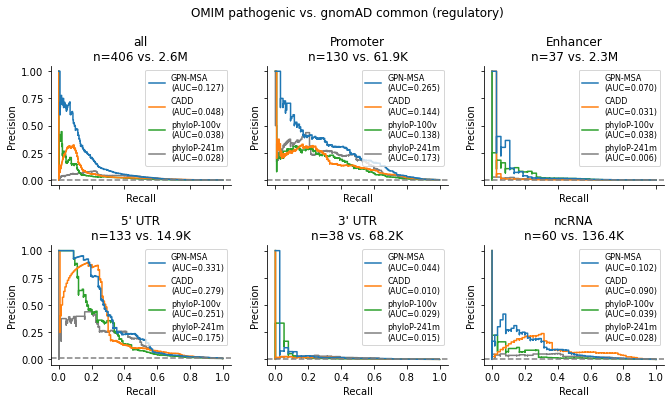

In [39]:
omim_curve_plot(
    #save_path="omim_pr_curves.svg",
)

In [40]:
examples = [
    (156_791_571, "Enhancer"),
    (113_105_781, "Promoter"),
    (22_130_605, "5' UTR"),
]

for pos, consequence in examples:
    print(pos, consequence)
    models = dataset_models["OMIM"][consequence]
    df = (
        V_omim
        .filter(consequence=consequence)
        .drop_nulls(subset=models)
    )
    df = (
        df
        .with_columns(
            pl.col(models).rank() / len(df) * 100
        )
    )
    df = df.filter(pos=pos).select(models).transpose(include_header=True).sort("column_0")
    df = df.with_columns(
        pl.col("column") + " -- " + pl.col("column_0").round_sig_figs(1).cast(str) + "\%"
    )
    print(', '.join(df["column"]))

156791571 Enhancer
GPN-MSA -- 0.004\%, phastCons-100v -- 0.6\%, CADD -- 2.0\%, phyloP-100v -- 5.0\%, phyloP-241m -- 50.0\%
113105781 Promoter
GPN-MSA -- 0.01\%, phyloP-100v -- 0.3\%, phastCons-100v -- 0.5\%, CADD -- 0.8\%, phyloP-241m -- 0.9\%, NT -- 30.0\%
22130605 5' UTR
CADD -- 0.2\%, GPN-MSA -- 0.3\%, phyloP-241m -- 1.0\%, phastCons-100v -- 2.0\%, phyloP-100v -- 6.0\%, NT -- 90.0\%


## gnomAD rare vs. common

In [41]:
consequence_models = dataset_models["gnomAD"]
results_gnomad = []
for c in tqdm(list(consequence_models.keys())):
    df_c = V_gnomad if c == "all" else V_gnomad.filter(consequence=c)
    df_c = df_c.drop_nulls(subset=consequence_models[c])
    n_pos, n_neg = df_c["label"].sum(), (~df_c["label"]).sum()
    for m in consequence_models[c]:
        odds_ratio = (
            get_odds_ratio(df_c.select(["label", pl.col(m).alias("score")]), [30, 60, 90])
            .with_columns(
                Consequence=pl.lit(c), Model=pl.lit(m),
                n_pos=pl.lit(n_pos), n_neg=pl.lit(n_neg),
            )
        )
        results_gnomad.append(odds_ratio)
results_gnomad = pl.concat(results_gnomad).to_pandas()
results_gnomad.head()

100%|██████████| 12/12 [03:09<00:00, 15.75s/it]


,n,Odds ratio,p_value,Consequence,Model,n_pos,n_neg
0,30,103.725214,0.000000e+00,all,GPN-MSA,252706195,5894721
1,60,76.681433,0.000000e+00,all,GPN-MSA,252706195,5894721
2,90,62.576950,0.000000e+00,all,GPN-MSA,252706195,5894721
3,30,17.571563,6.150975e-184,all,CADD,252706195,5894721
4,60,16.612214,0.000000e+00,all,CADD,252706195,5894721


In [45]:
replacements = {
    "5_prime_UTR": "5' UTR",
    "3_prime_UTR": "3' UTR",
    "upstream_gene": "upstream-of-gene",
    "downstream_gene": "downstream-of-gene",
    "non_coding_transcript_exon": "ncRNA",
    "splice_region": "splice-region",
    "start_or_stop": "start-or-stop",
}
results_gnomad['Consequence'] = results_gnomad['Consequence'].replace(replacements)

In [46]:
(results_gnomad[(results_gnomad.n==30) & ~results_gnomad.Model.isin(ablation_models)].p_value < 0.05).value_counts()

p_value
True    63
Name: count, dtype: int64

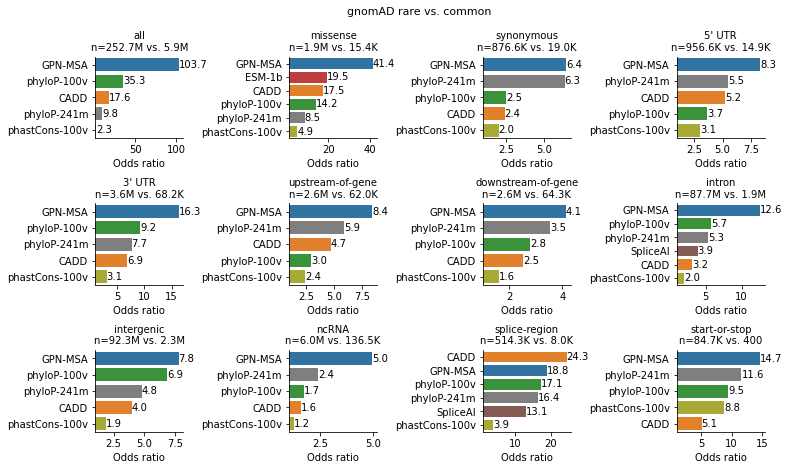

In [47]:
barplot(
    results_gnomad[
        (results_gnomad.n==30) &
        (results_gnomad.p_value < 0.05) &
        ~results_gnomad.Model.isin(ablation_models)
    ],
    "Odds ratio",
    "gnomAD rare vs. common",
    nrows=3, ncols=4, hspace=0.8, wspace=1.2, width=3, height=2.3, y=0.98,
    #save_path="gnomad_or.svg",
)

In [51]:
def get_subtitle(x):
    sample_size = f"n={format_number(x.n_pos)} vs. {format_number(x.n_neg)}"
    return f"{x.Consequence}\n{sample_size}"

results_gnomad["subtitle"] = results_gnomad.apply(get_subtitle, axis=1)

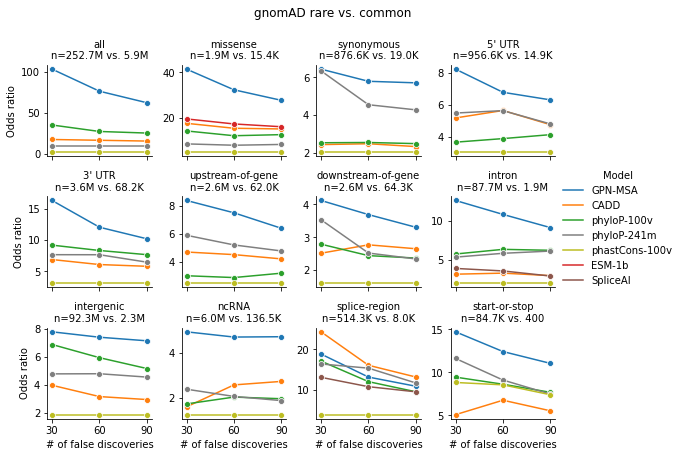

In [97]:
g = sns.relplot(
    data=results_gnomad[results_gnomad.p_value<=0.05].rename(columns={"n": "# of false discoveries"}),
    x="# of false discoveries",
    y="Odds ratio",
    hue="Model",
    col="subtitle",
    kind="line",
    marker="o",
    height=2,
    col_wrap=4,
    facet_kws={'sharey': False, 'sharex': True},
    palette=palette,
    #markersize=5,
)
g.set(xticks=[30, 60, 90])
g.set_titles(col_template="{col_name}", row_template="{row_name}");
plt.suptitle("gnomAD rare vs. common", y=1.05);
#plt.savefig(plot_dir + "gnomad_or_line.pdf", bbox_inches="tight")

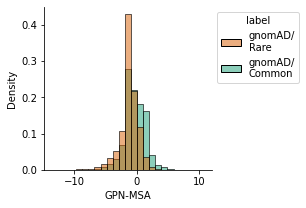

In [57]:
histplot_label(
    V_gnomad.select(["label", "GPN-MSA"]).sample(n=10_000_000, seed=42).to_pandas(),
    "gnomAD/\nRare", "gnomAD/\nCommon",
    #save_path="hist_gnomad.svg",
)

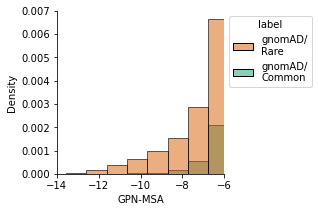

In [58]:
histplot_label(
    V_gnomad.select(["label", "GPN-MSA"]).sample(n=10_000_000, seed=42).to_pandas(),
    "gnomAD/\nRare", "gnomAD/\nCommon",
)
plt.xlim(-14, -6)
plt.ylim(0, 7e-3)
#plt.savefig(plot_dir + "hist_gnomad_zoom.svg", bbox_inches="tight")

### Stratifying by conservation

In [59]:
conservation_model = "phyloP-241m"
log_pval_thresh = -np.log10(0.05)  # 1.3
models_gnomad_strat = [m for m in dataset_models["gnomAD"]["all"] if m not in ablation_models]
V_gnomad_strat = (
    V_gnomad.drop_nulls(subset=models_gnomad_strat)
    .with_columns(
        pl.when(pl.col(conservation_model) < -log_pval_thresh).then(pl.lit("conserved"))
        .when(pl.col(conservation_model) > log_pval_thresh).then(pl.lit("accelerated"))
        .otherwise(pl.lit("neutral"))
        .alias("conservation")
    )
)
V_gnomad_strat["conservation"].value_counts()

conservation,count
str,u32
"""conserved""",18036217
"""accelerated""",21511215
"""neutral""",219053484


In [60]:
results_gnomad_strat = []
for c in tqdm(["all"] + list(V_gnomad_strat["conservation"].unique())):  
    df_c = V_gnomad_strat if c == "all" else V_gnomad_strat.filter(conservation=c)
    n_pos, n_neg = df_c["label"].sum(), (~df_c["label"]).sum()
    for m in models_gnomad_strat:
        odds_ratio = (
            get_odds_ratio(df_c.select(["label", pl.col(m).alias("score")]), [30, 60, 90])
            .with_columns(
                Consequence=pl.lit(c), Model=pl.lit(m),
                n_pos=pl.lit(n_pos), n_neg=pl.lit(n_neg),
            )
        )
        results_gnomad_strat.append(odds_ratio)
results_gnomad_strat = pl.concat(results_gnomad_strat).to_pandas()
results_gnomad_strat.head()

100%|██████████| 4/4 [03:26<00:00, 51.50s/it]


,n,Odds ratio,p_value,Consequence,Model,n_pos,n_neg
0,30,103.725214,0.000000e+00,all,GPN-MSA,252706195,5894721
1,60,76.681433,0.000000e+00,all,GPN-MSA,252706195,5894721
2,90,62.576950,0.000000e+00,all,GPN-MSA,252706195,5894721
3,30,17.571563,6.150975e-184,all,CADD,252706195,5894721
4,60,16.612214,0.000000e+00,all,CADD,252706195,5894721


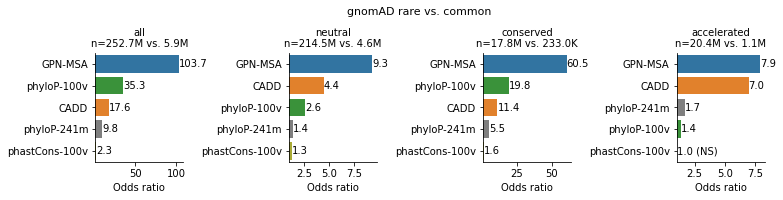

In [65]:
barplot(
    results_gnomad_strat[
        (results_gnomad_strat.n==30)
    ].sort_values(
        "Consequence",
        key=lambda x: pd.Categorical(x, categories=["all", "neutral", "conserved", "accelerated"]),
    ),
    "Odds ratio",
    "gnomAD rare vs. common",
    ncols=4, wspace=1.2, width=3, y=1.2,
    #save_path="gnomad_strat_or.svg",
)

## gnomAD Enformer set (low-frequency vs. common)

In [66]:
enformer_models = dataset_models["gnomAD_Enformer"]
results_enformer = []
df_c = V_enformer.drop_nulls(subset=enformer_models)
n_pos, n_neg = df_c["label"].sum(), (~df_c["label"]).sum()
for m in tqdm(enformer_models):
    odds_ratio = (
        get_odds_ratio(df_c.select(["label", pl.col(m).alias("score")]), [30, 60, 90])
        .with_columns(Model=pl.lit(m), n_pos=pl.lit(n_pos), n_neg=pl.lit(n_neg))
    )
    results_enformer.append(odds_ratio)
results_enformer = pl.concat(results_enformer).to_pandas()
results_enformer.head()

100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


,n,Odds ratio,p_value,Model,n_pos,n_neg
0,30,3.387194,1.141404e-11,GPN-MSA,7627870,6208835
1,60,3.202563,3.226402e-19,GPN-MSA,7627870,6208835
2,90,2.848963,6.328104e-22,GPN-MSA,7627870,6208835
3,30,1.181566,2.751448e-01,CADD,7627870,6208835
4,60,0.947404,6.551777e-01,CADD,7627870,6208835


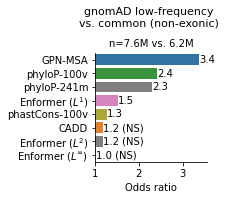

In [68]:
barplot(
    results_enformer[
        (results_enformer.n==30)
    ].replace({
        "Enformer_l1": r"Enformer ($L^1$)",
        "Enformer_l2": r"Enformer ($L^2$)",
        "Enformer_linf": r"Enformer ($L^\infty$)",
    }),
    "Odds ratio",
    "gnomAD low-frequency\nvs. common (non-exonic)",
    y=1.2,
    #save_path="gnomad_enformer_or.svg",
)

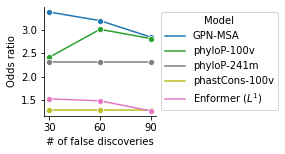

In [99]:
plt.figure(figsize=(2,2))
g = sns.lineplot(
    data=results_enformer[results_enformer.p_value < 0.05].rename(columns={"n": "# of false discoveries"}).replace({
        "Enformer_l1": r"Enformer ($L^1$)",
        "Enformer_l2": r"Enformer ($L^2$)",
        "Enformer_linf": r"Enformer ($L^\infty$)",
    }),
    x="# of false discoveries",
    y="Odds ratio",
    hue="Model",
    marker="o",
    palette=palette,
)
g.set(xticks=[30, 60, 90])
sns.despine()
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1));
#plt.savefig(plot_dir + "gnomad_enformer_or_line.pdf", bbox_inches="tight")

## gnomAD ablation set (rare vs. common subsample)

In [70]:
gnomad_ablation_models = dataset_models["gnomAD_ablation"]
results_gnomad_ablation = []
df_c = V_gnomad_ablation.drop_nulls(subset=gnomad_ablation_models)
n_pos, n_neg = df_c["label"].sum(), (~df_c["label"]).sum()
for m in tqdm(gnomad_ablation_models):
    odds_ratio = (
        get_odds_ratio(df_c.select(["label", pl.col(m).alias("score")]), [30, 60, 90])
        .with_columns(Model=pl.lit(m), n_pos=pl.lit(n_pos), n_neg=pl.lit(n_neg))
    )
    results_gnomad_ablation.append(odds_ratio)
results_gnomad_ablation = pl.concat(results_gnomad_ablation).to_pandas()
results_gnomad_ablation.head()

100%|██████████| 47/47 [00:41<00:00,  1.13it/s]


,n,Odds ratio,p_value,Model,n_pos,n_neg
0,30,41.764015,0.0,GPN-MSA,5913139,5905873
1,60,31.397468,0.0,GPN-MSA,5913139,5905873
2,90,25.725412,0.0,GPN-MSA,5913139,5905873
3,30,43.117784,0.0,multiz100way/89/128/64/True/defined.phastCons....,5913139,5905873
4,60,32.691802,0.0,multiz100way/89/128/64/True/defined.phastCons....,5913139,5905873


## Ablation study

In [75]:
results_ablation = [
    df[df.Model.isin(["GPN-MSA"] + ablation_models)]
    for df in [
        results_clinvar[["Model", "AUROC"]].rename(columns={"AUROC": "ClinVar"}),
        results_cosmic[["Model", "AUPRC"]].rename(columns={"AUPRC": "COSMIC"}),
        results_omim[results_omim.Consequence=="all"][["Model", "AUPRC"]].rename(columns={"AUPRC": "OMIM"}),
        results_gnomad_ablation.query('n==30')[["Model", "Odds ratio"]].rename(columns={"Odds ratio": "gnomAD"}),
    ]
]

results_ablation = reduce(lambda x, y: x.merge(y, on="Model", how="left"), results_ablation).replace("GPN-MSA", original_name)
results_ablation.head()

,Model,ClinVar,COSMIC,OMIM,gnomAD
0,multiz100way/89/256/128/True/defined.phastCons...,0.969064,0.363774,0.128492,42.956620
1,multiz100way/89/128/64/True/defined.phastCons....,0.968850,0.341206,0.112723,39.249922
2,multiz100way/89/256/128/True/defined.phastCons...,0.968727,0.358015,0.120241,32.746601
3,multiz100way/89/256/128/True/defined.phastCons...,0.968660,0.375973,0.107343,38.021701
4,multiz100way/89/128/64/True/defined.phastCons....,0.968525,0.354610,0.127152,41.764015


In [76]:
results_ablation[[col for col in results_ablation.columns if col not in ["Model", "Ablation"]]].corr(method="spearman")

,ClinVar,COSMIC,OMIM,gnomAD
ClinVar,1.000000,0.923913,0.495953,0.816374
COSMIC,0.923913,1.000000,0.407609,0.869912
OMIM,0.495953,0.407609,1.000000,0.433973
gnomAD,0.816374,0.869912,0.433973,1.000000


In [77]:
hparam_name = {
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Default",
    
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/False/True/True": "w/o MSA",
    "msa_multiz100way/89": "MSA frequency (no neural net)",
    "conservation_combination": "Combined phyloP and phastCons",

    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/[\d]+/30000/True/True/True": "Train on 50% most conserved",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_1.00_0.00/medium/0.1/[\d]+/30000/True/True/True": "Train on 100% of genome",
    
    r"multiz100way/99/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Include closest primates",
    r"multiz100way_mammals/51/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "51 mammals",
    r"multiz100way_vertebrates/51/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "51 vertebrates",
    
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/False/True": "Don't upweight conserved",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/False": "Don't replace non-conserved",
    
    r"multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Window size = 256",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.64": "Window size = 64",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.32": "Window size = 32",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.16": "Window size = 16",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.8": "Window size = 8",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.4": "Window size = 4",
}

results_ablation["Ablation"] = None
for k, v in hparam_name.items():
    results_ablation.loc[results_ablation.Model.str.match(k), "Ablation"] = v
results_ablation = results_ablation.dropna(subset="Ablation")
results_ablation.Ablation.value_counts()

Ablation
Window size = 256                3
Default                          3
Window size = 4                  3
Include closest primates         3
Window size = 8                  3
Train on 100% of genome          3
Train on 50% most conserved      3
Window size = 16                 3
51 mammals                       3
Don't replace non-conserved      3
51 vertebrates                   3
Window size = 32                 3
Don't upweight conserved         3
Window size = 64                 3
w/o MSA                          3
MSA frequency (no neural net)    1
Combined phyloP and phastCons    1
Name: count, dtype: int64

In [78]:
results_ablation = (
    results_ablation.groupby("Ablation")[
        [col for col in results_ablation.columns if col not in ["Model", "Ablation"]]
    ].agg([
        "mean",
        #"std",
        #"median",
        "max",
    ])
)
results_ablation.index.name = None
results_ablation = results_ablation.loc[hparam_name.values()]
results_ablation = results_ablation.round(3)
results_ablation

ClinVar        COSMIC          OMIM         \
                                 mean    max   mean    max   mean    max   
Default                         0.969  0.969  0.348  0.355  0.124  0.133   
w/o MSA                         0.584  0.585  0.012  0.012  0.000  0.000   
MSA frequency (no neural net)   0.950  0.950  0.270  0.270  0.031  0.031   
Combined phyloP and phastCons   0.928  0.928  0.141  0.141  0.039  0.039   
Train on 50% most conserved     0.963  0.963  0.241  0.257  0.125  0.139   
Train on 100% of genome         0.960  0.961  0.210  0.224  0.120  0.122   
Include closest primates        0.954  0.956  0.214  0.219  0.139  0.156   
51 mammals                      0.964  0.965  0.323  0.325  0.073  0.076   
51 vertebrates                  0.967  0.967  0.342  0.347  0.101  0.108   
Don't upweight conserved        0.967  0.967  0.303  0.309  0.133  0.152   
Don't replace non-conserved     0.966  0.967  0.333  0.340  0.111  0.112   
Window size = 256               0.969  0.969  0.366  0.376  0.119  0.128   
Window size = 64                0.968  0.968  0.340  0.348  0.111  0.119   
Window size = 32                0.967  0.967  0.323  0.328  0.108  0.121   
Window size = 16                0.964  0.965  0.246  0.250  0.095  0.106   
Window size = 8                 0.961  0.961  0.188  0.209  0.080  0.086   
Window size = 4                 0.942  0.943  0.131  0.155  0.052  0.053   

                               gnomAD          
                                 mean     max  
Default                        41.377  43.118  
w/o MSA                         2.773   3.093  
MSA frequency (no neural net)  15.122  15.122  
Combined phyloP and phastCons  13.919  13.919  
Train on 50% most conserved    32.116  35.286  
Train on 100% of genome        27.964  30.717  
Include closest primates       24.674  26.721  
51 mammals                     41.381  43.408  
51 vertebrates                 41.624  46.792  
Don't upweight conserved       37.094  39.991  
Don't replace non-conserved    41.853  45.213  
Window size = 256              37.908  42.957  
Window size = 64               37.478  39.522  
Window size = 32               36.664  38.866  
Window size = 16               29.203  31.623  
Window size = 8                21.159  21.943  
Window size = 4                13.457  14.789

In [80]:
print(results_ablation.to_latex(escape="latex", float_format="%.3f"))

\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{2}{r}{ClinVar} & \multicolumn{2}{r}{COSMIC} & \multicolumn{2}{r}{OMIM} & \multicolumn{2}{r}{gnomAD} \\
 & mean & max & mean & max & mean & max & mean & max \\
\midrule
Default & 0.969 & 0.969 & 0.348 & 0.355 & 0.124 & 0.133 & 41.377 & 43.118 \\
w/o MSA & 0.584 & 0.585 & 0.012 & 0.012 & 0.000 & 0.000 & 2.773 & 3.093 \\
MSA frequency (no neural net) & 0.950 & 0.950 & 0.270 & 0.270 & 0.031 & 0.031 & 15.122 & 15.122 \\
Combined phyloP and phastCons & 0.928 & 0.928 & 0.141 & 0.141 & 0.039 & 0.039 & 13.919 & 13.919 \\
Train on 50\% most conserved & 0.963 & 0.963 & 0.241 & 0.257 & 0.125 & 0.139 & 32.116 & 35.286 \\
Train on 100\% of genome & 0.960 & 0.961 & 0.210 & 0.224 & 0.120 & 0.122 & 27.964 & 30.717 \\
Include closest primates & 0.954 & 0.956 & 0.214 & 0.219 & 0.139 & 0.156 & 24.674 & 26.721 \\
51 mammals & 0.964 & 0.965 & 0.323 & 0.325 & 0.073 & 0.076 & 41.381 & 43.408 \\
51 vertebrates & 0.967 & 0.967 & 0.342 & 0.347 & 0.101 & 0.108 &

## ClinVar pathogenic vs. benign (missense)

In [82]:
models_clinvar_benign = dataset_models["ClinVar_benign"]
V_clinvar_benign = V_clinvar_benign.drop_nulls(subset=models_clinvar_benign)
n_pos, n_neg = V_clinvar_benign["label"].sum(), (~V_clinvar_benign["label"]).sum()
rows = []
for m in tqdm(models_clinvar_benign):
    y_true = V_clinvar_benign["label"]
    y_score = -V_clinvar_benign[m]
    AUROC = roc_auc_score(y_true, y_score)
    AUPRC = average_precision_score(y_true, y_score)
    rows.append(["all", m, AUROC, AUPRC, n_pos, n_neg])
results_clinvar_benign = pd.DataFrame(
    rows, columns=["Consequence", "Model", "AUROC", "AUPRC", "n_pos", "n_neg"]
).sort_values("AUROC", ascending=False)
results_clinvar_benign.head()

100%|██████████| 6/6 [00:00<00:00, 27.50it/s]


,Consequence,Model,AUROC,AUPRC,n_pos,n_neg
5,all,ESM-1b,0.914224,0.904751,21275,26993
1,all,CADD,0.913639,0.877106,21275,26993
0,all,GPN-MSA,0.906944,0.876353,21275,26993
2,all,phyloP-100v,0.855577,0.808643,21275,26993
3,all,phyloP-241m,0.803965,0.704849,21275,26993


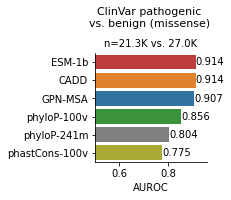

In [89]:
barplot(
    results_clinvar_benign,
    "AUROC",
    "ClinVar pathogenic\nvs. benign (missense)",
    y=1.2,
    #save_path="clinvar_benign_auroc.pdf",
)

## DMS (missense)

In [85]:
models_dms = dataset_models["DMS"]
V_dms = V_dms.drop_nulls(subset=models_dms)
rows = []
for DMS in V_dms["DMS"].unique(maintain_order=True):
    V_c = V_dms.filter(DMS=DMS)
    for m in models_dms:
        rows.append([DMS, m, spearmanr(V_c["label"], V_c[m])[0]])
results_dms = pd.DataFrame(
    rows, columns=["Consequence", "Model", "Spearman"]
)
results_dms.head(6)

,Consequence,Model,Spearman
0,DMS_TADBP_HUMAN_Bolognesi_2019,GPN-MSA,-0.071710
1,DMS_TADBP_HUMAN_Bolognesi_2019,CADD,0.046299
2,DMS_TADBP_HUMAN_Bolognesi_2019,phyloP-100v,-0.068083
3,DMS_TADBP_HUMAN_Bolognesi_2019,phyloP-241m,0.077465
4,DMS_TADBP_HUMAN_Bolognesi_2019,phastCons-100v,0.016584
5,DMS_TADBP_HUMAN_Bolognesi_2019,ESM-1b,-0.069276


In [86]:
results_dms.groupby("Model")["Spearman"].mean().sort_values(ascending=False)

Model
ESM-1b            0.423723
CADD              0.337638
GPN-MSA           0.322003
phyloP-100v       0.230236
phastCons-100v    0.156252
phyloP-241m       0.141147
Name: Spearman, dtype: float64

In [87]:
results_dms.groupby("Model")["Spearman"].median().sort_values(ascending=False)

Model
ESM-1b            0.454056
GPN-MSA           0.354891
CADD              0.320596
phyloP-100v       0.273353
phyloP-241m       0.151679
phastCons-100v    0.141818
Name: Spearman, dtype: float64

In [88]:
V_dms["DMS"].unique().shape

(31,)

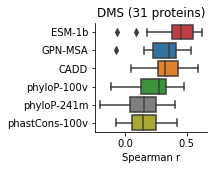

In [92]:
plt.figure(figsize=(2,2))
g = sns.boxplot(
    data=results_dms, y="Model", x="Spearman", palette=palette,
    order=results_dms.groupby("Model")["Spearman"].median().sort_values(ascending=False).index.values
);
plt.xlabel("Spearman r")
plt.ylabel("")
plt.title("DMS (31 proteins)")
sns.despine()
#plt.savefig(plot_dir + "dms.pdf", bbox_inches="tight")